### Imports

In [1]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tqdm import tqdm
from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score

np.random.seed(42)

# Custom imports
from lattice import Lattice

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

### Generate data

In [2]:
# 10 x 10 lattice
# 60 temperatures, 500 thermalization iterations

# For a temperature range, thermalize a lattice, then
# take a few hundred steps, recording energy and magnetization.
# Store the means to plot next.
# This takes about 60s with one modern core.

# Thermalization and measurement steps
ntherm = 500
nmeasure = 200

# points = array with (T, mean(E), abs(mean(M)), var(E))
# with the mean and variance evaluated for a list of many temperatures
points = []
# Storing nmeasure / nsparse data points
nsparse = 10
# points_full = array with (T, E, abs(M))
# for several different configurations per temperature
points_full=[]
for T in tqdm(np.arange(4.0,1.0,-0.05)):
    lat = Lattice(N=10,T=T)
    for _ in range(ntherm):
        lat.step()
    Es = []
    Ms = []

    for istep in range(nmeasure): 
        lat.step()
        Es.append(lat.get_energy())
        Ms.append(lat.get_avg_magnetization())
        if (istep%nsparse==0):
            points_full.append((T,Es[-1],np.abs(Ms[-1])))           
    Es = np.array(Es)
    Ms = np.array(Ms)
    points.append((T,Es.mean(),np.abs(Ms.mean()),Es.var()))
points = np.array(points)
points_full = np.array(points_full)

100%|██████████████████████████████████████████████████████████████| 60/60 [01:47<00:00,  1.79s/it]


In [3]:
# Calculate critical temperature
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


We want to use the full data set, points-full, as our dataset to the network. This is because this is the full data set.

In [8]:
# Normalize data. Remove mean and divide with standard deviation
def normalize(train_data, test_data):
    '''
    Normalize train_data and test_data using the mean and standard deviation from the 
    train_data set. This is as to not contaminate the test_data and introduce correlations. 
    '''
    # Iterate over all columns in training data, and normalize all data using training data!
    for i in range(1,2+1):
        # We want to normalize columns 1 and 2 - not T, will be one-hot encoded!
        mean = train_data[:,i].mean(axis=0)
        std = train_data[:,i].std(axis=0)
        assert (std-0) > 1e-5  # Check so standard deviation is not zero!
        train_data[:,i] -= mean
        train_data[:,i] /= std
        test_data[:,i] -= mean
        test_data[:,i] /= std
    return train_data, test_data


def data_split(data, train_fraction, seed, shuffle):
    '''Shuffle the dataset, and then split into two fractions'''
    if shuffle:
        np.random.shuffle(data)  # Shuffles along the first dimension, i.e. along the row dimension. 
    # Split into two parts, with the train_set being train_frac
    split_idx = int(data.shape[0]*train_fraction)
    test_data = data[:split_idx]
    train_data = data[split_idx:]
    return train_data, test_data


def one_hot_labels(data, Tc):
    '''One hot encodes the first column in data. Use boolean expressions.'''
    bool_arr = data[:,0] > Tc
    data[:,0] = bool_arr
    return data
    
    
def prepare_data(full_data, Tc, test_fraction=0.3, seed=1, shuffle=True):
    '''
    One-hot encodes T-column as 0 if T < Tc and 1 if T > Tc.  
    Shuffles and splits the dataset into a training and a test set. 
    Finally normalizes the test and train sets using the train set.
    '''
    np.random.seed(seed)
    data = np.copy(full_data) # Make a copy, as not to overwrite original data
    data = one_hot_labels(data, Tc)  # One-hot encode labels
    train_data, test_data = data_split(data, test_fraction, seed, shuffle)  # Shuffle and split the dataset
    train_data, test_data = normalize(train_data, test_data)
    
    return(train_data, test_data)
    
train_data, test_data = prepare_data(points_full, Tc, 0.3, seed=1)

In [5]:
#****************** TEST CELL *******************
# Normalize data. Remove mean and divide with standard deviation
def normalize(train_data, test_data):
    '''
    Normalize train_data and test_data using the mean and standard deviation from the 
    train_data set. This is as to not contaminate the test_data and introduce correlations. 
    '''
    # Iterate over all columns in training data, and normalize all data using training data!
    for i in range(1,2+1):
        # We want to normalize columns 1 and 2 - not T, will be one-hot encoded!
        mean = train_data[:,i].mean(axis=0)
        std = train_data[:,i].std(axis=0)
        assert (std-0) > 1e-5  # Check so standard deviation is not zero!
        train_data[:,i] -= mean
        train_data[:,i] /= std
        test_data[:,i] -= mean
        test_data[:,i] /= std
    return train_data, test_data


def data_split(one_hot_data, data, test_fraction, seed, shuffle):
    '''Shuffle the dataset, and then split into two fractions'''
    if shuffle:
        np.random.shuffle(data)  # Shuffles along the first dimension, i.e. along the row dimension. 
    # Split into two parts, with the train_set being train_frac
    split_idx = int(data.shape[0]*test_fraction)
    test_data = one_hot_data[:split_idx]
    test_data_orig = data[:split_idx]
    train_data = one_hot_data[split_idx:]
    train_data_orig = data[split_idx:] 
    return train_data, test_data, train_data_orig, test_data_orig


def one_hot_labels(data, Tc):
    '''One hot encodes the first column in data. Use boolean expressions.'''
    one_hot_data = np.copy(data)
    bool_arr = data[:,0] > Tc
    one_hot_data[:,0] = bool_arr
    return one_hot_data
    
    
def prepare_data(full_data, Tc, test_fraction=0.3, seed=1, shuffle=True):
    '''
    One-hot encodes T-column as 0 if T < Tc and 1 if T > Tc.  
    Shuffles and splits the dataset into a training and a test set. 
    Finally normalizes the test and train sets using the train set.
    '''
    np.random.seed(seed)
    data = np.copy(full_data) # Make a copy, as not to overwrite original data
    one_hot_data = one_hot_labels(data, Tc)  # One-hot encode labels
    train_data, test_data, train_data_orig, test_data_orig = data_split(one_hot_data, data, test_fraction, seed, shuffle)  # Shuffle and split the dataset
    train_data, test_data = normalize(train_data, test_data)
    
    return train_data, test_data, train_data_orig, test_data_orig
    
train_data, test_data, train_data_orig, test_data_orig = prepare_data(points_full, Tc, 0.3, seed=1)
#****************** TEST CELL *******************

Create the neuron. The weight vector $w$ has shape $(n_{features})$, which in our case is 2, corresponding to $E$ and $|m|$. $b$ is our bias term for our neuron.

Our cost function is cross-entropy, with a regularizer term with weight $\alpha$. With our sigmoid activation function, our cross-entropy for our $i$ instances of data becomes:

$$ C(w) = - \sum_i t_i \log{\frac{e^{w\cdot x_i + b}}{1+e^{w\cdot x_i + b}}} + (1-t_i) \log \left(1 + \frac{e^{w\cdot x_i + b}}{1+e^{w\cdot x_i + b}} \right) = $$

$$ =  - \sum_i t_i (w\cdot x_i + b) - t_i \log{\left(1+e^{w\cdot x_i + b}\right)} + (1-t_i) \log(1) - (1-t_i) \log{\left(1+e^{w\cdot x_i + b}\right)}$$ 

$$ = - \sum_i t_i (w\cdot x_i + b) - \log{\left(1+e^{w\cdot x_i + b}\right)}.$$

If we take the gradient with regards to $b$, we obtain:

$$ - \sum_i t_i - \frac{e^{w\cdot x_i + b}}{1+e^{w\cdot x_i + b}} = -\sum_i t_i-y_i = - \sum_i e_i,$$

and if we take the gradient with regards to $w$ we obtain:

$$ - \sum_i t_i x_i - \frac{x_i e^{w\cdot x_i + b}}{1+e^{w\cdot x_i + b}} = -\sum_i x_i(t_i-y_i) = - \vec{x}^T \cdot \vec{e} .$$

We can summarize the total gradient in terms of the design matrix $X=(\vec{1}, \vec{E}, \vec{m})$ of shape $(n_{instances}, n_{features})$:

$$ \nabla C = - \vec{X}^T \cdot \vec{e} $$

where  $e$ has shape $(n_instances)$. The contribution to both of these terms is the gradient of the regularizer:

$$ E(w,b) = \frac{1}{2} \left( \sum_i w_i^2 + b^2 \right) => \nabla E = \vec{[b, w]},$$

where $\vec{[b, w]}$ is to be interpreted as bias term appended to the weight vector $w$. The total gradient is thus:

$$ \nabla C_w = - \vec{X}^T \cdot \vec{e} + \vec{[b, w]}.$$

The shift to our weights is hence, with learning rate $eta$: 

$$ \delta w = -\eta \nabla C_w = \eta \left(\vec{X}^T \cdot \vec{e} - \vec{[b, w]} \right)$$

calc_accuracy passes unit tests: True


C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply



Final test accuracy was: 0.950


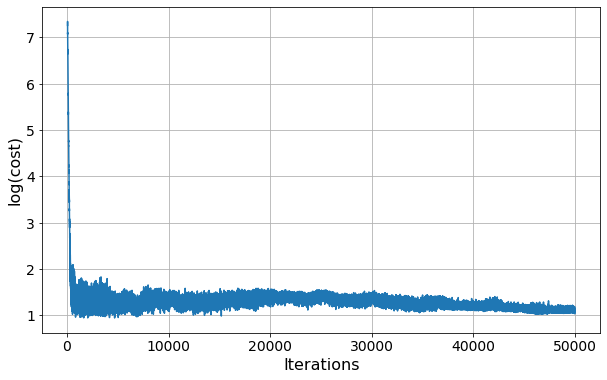

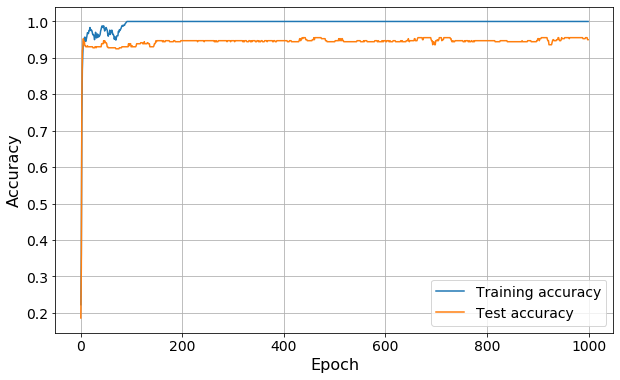

In [20]:
def calc_accuracy(p, t):
    '''Calculates the accuracy for prediction p compared to targets t.'''
    nbr_correct = np.sum(np.around(p) == t)
    return nbr_correct/len(p)

# Test calc_accuracy
p_test = [0.6, 0.4, 0.05, 1]
t_test = [1, 1, 1, 1]
print(f'calc_accuracy passes unit tests: {0.5 == calc_accuracy(p_test, t_test)}')
    

def sigmoid(a):
    '''¨Returns the sigmoid value of the activation a.'''
    return 1/(1+np.exp(-a))


def feed_forward(x, w, b):
    '''Performs the feed-forward pass for our neuron. Return the activation.'''
    z = x@w + b
    return sigmoid(z)  
   

def cost_function(y, t, b_w, alpha):
    '''
    Calculates the cost-function for output data y and labels t. 
    Also utilizes weight regularization.
    '''
    cost = - np.sum( t*np.log(y) + (1-t)*np.log(1-y) )
    reg = 1/2 * np.sum(b_w**2)
    return cost + alpha*reg
    
    
def train_neuron(train_data, test_data, epochs=1000, batch_size=50, alpha=1, eta=0.01, seed=1):
    '''Trains the neuron. Randomize weights and bias term. Use batch gradient descent.'''
    # Set the seed
    np.random.seed(seed)
    # Randomize the weights
    w = 100*np.random.uniform(size=2)  # TODO change start?
    b = 100*np.random.uniform(size=1)
    # Pick out the training data and the targets
    x = train_data[:,1:]
    t = train_data[:,0]
    # Pick out the test data
    x_test = test_data[:,1:]
    t_test = test_data[:,0]
    # Iterate over all instances of data
    costs = []
    train_accuracies = []
    test_accuracies = []
    for epoch in tqdm_notebook(range(epochs)):
        # Train the network in epochs - one epoch goes through all the data
        # Shuffle the x and t vectors at the beginning of each epoch
        shuffle_idx = np.random.randint(0, len(x)-1, len(x))
        x = x[shuffle_idx]
        t = t[shuffle_idx]
        
        # Split into batches of equal size
        x_batches = np.array_split(x, batch_size)
        t_batches = np.array_split(t, batch_size)
        for idx, x_b in enumerate(x_batches):
            x_b = np.expand_dims(x_b, -1)
            t_b = t_batches[idx]
            
            # Create design matrix
            X = np.concatenate((x_b[:,0]**0, x_b[:,0], x_b[:,1]), axis=1)
            
            # Squeeze x_i to remove unnecessary dimension
            x_b = np.squeeze(x_b)
            
            # Calculate the network output
            y_b = feed_forward(x_b, w, b)
            
            # Create vector of bias and weights
            bias_and_weights = np.concatenate((b, w), axis=0)  # [b, w]
            
            # Calculate the cost and do a prediction - for monitoring training
            c_b = cost_function(y_b, t_b, bias_and_weights, alpha)
            costs.append(c_b)
            
            # Update to our weights - last term is from regularizer
            delta_bias_and_weights = (X.T).dot(t_b-y_b) - alpha*bias_and_weights
            
            # Update weights and biases
            b += eta*delta_bias_and_weights[0]
            w += eta*delta_bias_and_weights[1:]
            
        # Do a predict on train data set, for monitoring training.
        train_acc = calc_accuracy(feed_forward(x, w, b), t)
        train_accuracies.append(train_acc)
        test_acc = calc_accuracy(feed_forward(x_test, w, b), t_test)
        test_accuracies.append(test_acc)
        # TODO add losses?
    print(f'Final test accuracy was: {test_acc:.3f}')
    fig1, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(np.log(costs))
    ax1.set_ylabel(r'log(cost)')
    ax1.set_xlabel(r'Iterations')
    ax1.grid()
    
    fig2, ax2 = plt.subplots(figsize=(10,6))
    ax2.plot(train_accuracies, label='Training accuracy')
    ax2.plot(test_accuracies, label='Test accuracy')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='best')
    ax2.grid()
    # Return the optimized weights
    return w, b
    
w_star, b_star = train_neuron(train_data, test_data)

#### Todo talk with Simon about this - use full data set?

In [15]:
# OLD UNNECESSARY CODE

def find_idx_nearest(array, value):
    arr = np.asarray(array)
    idx = (np.abs(arr - value)).argmin()
    return idx


# Plot the decision boundary - it will be a line in E-m space
T = points_full[:,0]
E = points_full[:,1]
M = points_full[:,2]
high_T = points_full[:,0]>Tc
low_T = points_full[:,0]<Tc
E_M_high = points_full[high_T][:,1:]
E_M_low = points_full[low_T][:,1:]


# Prepare a new decision set of data - don't shuffle to corrolate to E and m
# This is because we need it to be normalized!
decision_set, _  = prepare_data(points_full, Tc, test_fraction=0, seed=1, shuffle=False)
norm_e_m = decision_set[:,1:]  # Extract just E and m data

# Iterate over all E and m values; save the idx closest to 0.5
e_norm = norm_e_m[:,0]
m_norm = norm_e_m[:,1]
decision_boundary_idx = []

predictions = np.zeros((len(e_norm), len(m_norm)))

for i, e in tqdm_notebook(enumerate(e_norm)):
    for j, m in enumerate(m_norm):
        predictions[i,j] = feed_forward([e,m], w_star, b_star)
    # Extract the idx j closest to p=0.5 for this e
    idx = find_idx_nearest(predictions[i,:], 0.5) 
    decision_boundary_idx.append(idx)

# # We want to create a meshgrid - for all m, we want to know at which E the prediction is at 0.5
# ee, mm = np.meshgrid(norm_e_m[:,0], norm_e_m[:,1])
# decision_input = np.concatenate((ee.ravel(), mm.ravel()))

# # Create a matrix with each values for ee and mm - goes through all combinations
# decision_input = np.c_[ee.ravel(), mm.ravel()]

# # Create a refernce, non-normalized, matrix, a table to look up the E and m values in
# ee_ref, mm_ref = np.meshgrid(E, m)
# reference_matrix = np.c_[ee_ref.ravel(), mm_ref.ravel()]

# # Do a prediction
# decision_output = feed_forward(decision_input, w_star, b_star)

# # Find index closest to 0.5
# idxs = find_idx_nearest()


The decision boundary is defined as:

$$ p(T=1) = \frac{1}{2} \rightarrow \frac{1}{1+e^{-a} = \frac{1}{2}}.$$ 
This implies:
$$ 0 = a = w \cdot x + b = w_0 E + w_1 m + b,$$
which gives us the equation for the decision boundary:
$$ m = - \frac{w_0}{w_1}E - b $$

In [10]:
print(E.shape)
print(M.shape) 
print(E[decision_boundary_idx])

(1200,)
(1200,)


NameError: name 'decision_boundary_idx' is not defined

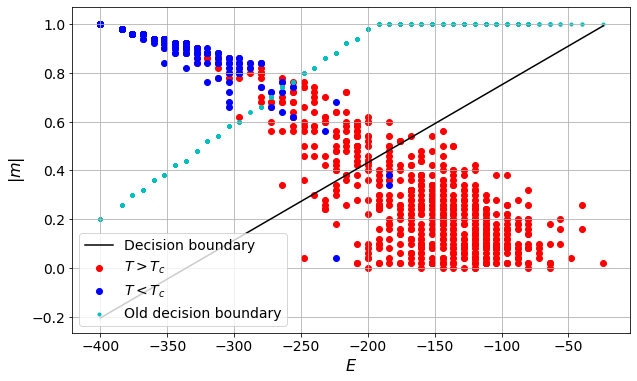

In [16]:
# Plot the data and the decision boundary
def dec_boundary(E, w, b):
    return -w[0]/w[1]*E - b
    
E_space = np.linspace(E.min(), E.max())
M_space = np.linspace(M.min(), M.max())
# E_space norm
E_norm = (E_space-E_space.mean())/E_space.std()  # Normalize E
m_norm = dec_boundary(E_norm, w_star, b_star)  # Calculate m using weights
dec_bound = m_norm*M_space.std() + M.mean()  # Scale back m 


fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(E_M_high[:,0],E_M_high[:,1],c='r', label=r'$T>T_c$')
ax.scatter(E_M_low[:,0],E_M_low[:,1],c='b', label=r'$T<T_c$')
ax.plot(E_space, dec_bound, c='k', label='Decision boundary')
ax.scatter(E, M[decision_boundary_idx], c='c', marker='.', label='Old decision boundary')
ax.set_xlabel("$E$")
ax.set_ylabel("$|m|$")
ax.grid()
ax.legend(loc='best')



### Extra - Predict the critical temperature
Note - This fit doesn't work well if only evaluated on the test set, since the split is bad. Here it is evaluated for **all** data.

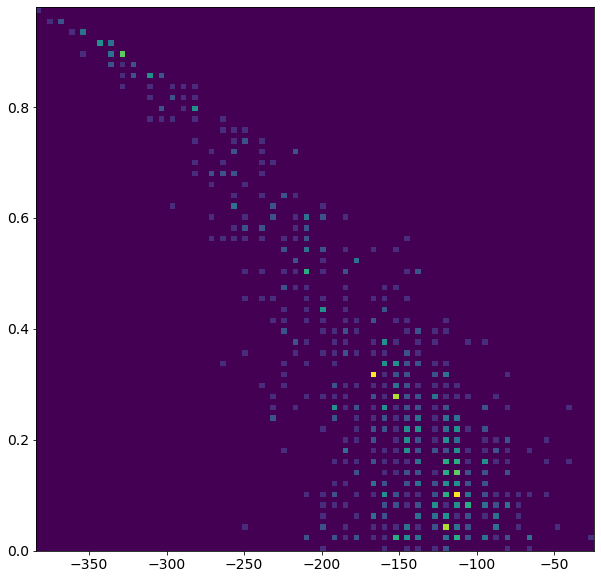

In [17]:
# Create a heatmap to see which is more plausible


fig, ax = plt.subplots(figsize=(10,10))
heatmap, _, _, _ = ax.hist2d(E_M_high[:,0],E_M_high[:,1], bins=100)

The predicted critical temperature is 2.19 K. The true critical temperature is 2.27 K.


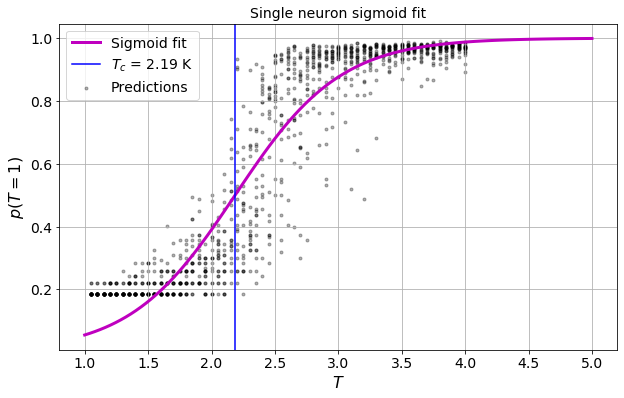

In [21]:
def sigmoid_fun(x, a, b):
    '''a is scale, b is location. Location is where the curve crosses 0.5.'''
    return 1/(1+np.exp(-a*(x-b)))


#T = test_data_orig[:,0]  
T = points_full[:,0]
# Make a prediction on the test set. These corresponds to our temperatures T
T_pred = (feed_forward(norm_e_m, w_star, b_star)).squeeze()  # Squeeze the unnecessary dimension from predict

# Fit a sigmoid to our predictions
popt, pcov = curve_fit(sigmoid_fun, T, T_pred, p0=[3, 1], method='dogbox')
t_c_fit = popt[1]
print(f'The predicted critical temperature is {t_c_fit:.2f} K. The true critical temperature is {Tc:.2f} K.')

#res = minimize_scalar(objective, bracket=(4, 10), args=tuple(popt2))

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(T, T_pred, marker='.', c='k', alpha=0.3, label='Predictions')
T_space = np.linspace(1, 5, 100)
ax.plot(T_space, sigmoid_fun(T_space, popt[0], popt[1]), color='m', linewidth=3, label="Sigmoid fit")
ax.axvline(t_c_fit, color='b', label=fr'$T_c$ = {t_c_fit:.2f} K')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$p(T=1)$')
ax.set_title('Single neuron sigmoid fit')
ax.grid()
ax.legend(loc='best')